In [1]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import importlib.util
import os
import pickle
from oggm import utils
import copy
import seaborn as sns

from agile1d.sandbox.glaciers_for_idealized_experiments import experiment_glaciers

# add my functions and data paths

In [2]:
output_folder = 'plots'

## functions

In [3]:
paths_to_functions = [
    '/home/www/pschmitt/agile/final_runs_glacier_states/tools_for_analysis/',
]

for path in paths_to_functions:
    sys.path.append(path)

from df_analysis import filter_dataframe, sort_dataframe, return_settings
from get_reference_glaciers import get_fl_at_year, fp_gdirs
from plot_statistics import plot_stats_per_iteration, plot_stat_metrics
from plot_along_fl import add_bed_h_and_volume_along_fl
from calculate_statistics import get_stats_for_all_iterations

2025-04-04 11:29:43: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-04 11:29:43: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-04 11:29:43: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-04-04 11:29:43: oggm.workflow: init_glacier_directories by parsing all available folders (this takes time: if possible, provide rgidf instead).


## experiment settings

In [4]:
experiment_dir = '/home/www/pschmitt/agile/final_runs_glacier_states/full_run/'

In [5]:
from experiment_file_fg_oggm import experiment_options

# Set working settings for plot

In [6]:
lam = 'lam9'
obs = 'obs6'
reg = 'reg0'

# Define colors

In [7]:
plt.style.use('seaborn-v0_8-colorblind')

# Create plot Cost function and stats per iteration (fg_oggm and fg_glabtop)

In [8]:
main_results_dir = '/home/www/pschmitt/agile/final_runs_glacier_states/full_run/results_old/'

In [9]:
def get_ds_oggm(glacier, glacier_state):
    fp_pkl = os.path.join(
        main_results_dir,
        f'{glacier}_{glacier_state}_full_run_fg_oggm_{lam}_{obs}_{reg}.pkl')
    with open(fp_pkl, 'rb') as handle:
        ds_oggm = pickle.load(handle)
    return ds_oggm

In [10]:
def get_ds_glabtop(glacier, glacier_state):
    fp_pkl = os.path.join(
        main_results_dir,
        f'{glacier}_{glacier_state}_full_run_fg_glabtop_{lam}_{obs}_{reg}.pkl')
    with open(fp_pkl, 'rb') as handle:
        ds_glabtop = pickle.load(handle)
    return ds_glabtop

## function for plotting cost with terms

In [11]:
def get_terms_of_cost_fct(ds):
    data = ds.c_terms_description
    cost_lambda = ds.attrs['cost_lambda']
    reg_terms = ds.attrs['regularisation_terms']
    if 'smoothed_bed' in reg_terms:
        reg_scaling_bed = reg_terms['smoothed_bed']
    else:
        reg_scaling_bed = 0

    if 'smoothed_flux' in reg_terms:
        reg_scaling_flux = reg_terms['smoothed_flux']
    else:
        reg_scaling_flux = 0

    cost_term_names = {
        'fl_surface_h:m': '2000',
        'dmdtda:kg m-2 yr-1': '2000-2020',
        'volume:km3': '2000',
    }
    if reg_scaling_bed != 0:
        cost_term_names['smoothed_bed'] = None
    if reg_scaling_flux != 0:
        cost_term_names['smoothed_flux'] = None

    c_sfc_h = []
    c_dmdtda = []
    c_v = []
    reg_bed = []
    reg_flux = []
    all_vars = [c_sfc_h, c_dmdtda, c_v]
    if reg_scaling_bed != 0:
        all_vars.append(reg_bed)
    if reg_scaling_flux != 0:
        all_vars.append(reg_flux)
    
    for i in data.iteration:
        data_dict = data.isel(iteration=i).item()

        for var, name in zip(all_vars, cost_term_names):
            if cost_term_names[name] is None:
                var.append(data_dict[name].item())
            else:
                var.append(data_dict[name][cost_term_names[name]].item())

    c_sfc_h = np.array(c_sfc_h) / 3
    c_dmdtda = np.array(c_dmdtda) / 3
    c_v = np.array(c_v) / 3

    if reg_scaling_bed != 0:
        reg_bed = np.array(reg_bed) / 2 * cost_lambda * reg_scaling_bed
    if reg_scaling_flux != 0:
        reg_flux = np.array(reg_flux) / 2 * cost_lambda * reg_scaling_flux

    ds = xr.Dataset({
        'fl_surface_h:m': (('iteration'), c_sfc_h),
        'dmdtda:kg m-2 yr-1': (('iteration'), c_dmdtda),
        'volume:km3': (('iteration'), c_v),
    },
                    coords={'iteration': data.iteration}
                   )
    
    if reg_scaling_bed != 0:
        ds['smoothed_bed'] = (('iteration'), reg_bed)
    if reg_scaling_flux != 0:
        ds['smoothed_flux'] = (('iteration'), reg_flux)

    return ds

In [12]:
def plot_stacked_cost(ds_input, ax, ax_rel=None):
    '''plots stacked cost terms and relative cost terms on two axis'''

    ds = get_terms_of_cost_fct(ds_input)

    df = ds.to_dataframe()

    cumulative_df = df.cumsum(axis=1)

    cost_labels = {
        'fl_surface_h:m': r'$sfc_{2000}$',
        'dmdtda:kg m-2 yr-1': r'$\Delta M_{2000/2020}$',
        'volume:km3': r'$V_{2000}$',
        'smoothed_bed': r'$\mathcal{J}_{reg,bed}$ * $\lambda$ ' + f"({ds_input.attrs['cost_lambda']})",
    }

    for i, column in enumerate(cumulative_df.columns):
        if i == 0:
            ax.fill_between(ds['iteration'], cumulative_df[column],
                            label=cost_labels[column],
                            lw=0, zorder=2)
        else:
            ax.fill_between(ds['iteration'], cumulative_df[column],
                            cumulative_df[cumulative_df.columns[i - 1]],
                            label=cost_labels[column],
                            lw=0, zorder=2)

    ax.plot(cumulative_df[cumulative_df.columns[-1]].values,
            'k.-', lw=0.5, label=r'total cost $\mathcal{J}$')

    if ax_rel:
        total_cost = ds['fl_surface_h:m'] + ds['dmdtda:kg m-2 yr-1'] + ds['volume:km3'] + ds['smoothed_bed']
        
        for var in ds:
            ax_rel.plot(ds[var] / total_cost * 100, '.-')#, label=cost_labels[var])

        #ax_rel.legend(ncol=2)
        ax_rel.set_ylabel('% of\ntotal cost')

## actual plotting function

In [19]:
def plot_cost_and_stats(ds, glacier, glacier_state, ax_cost, ax_stats, title=None, output_filename='', ds_ref=None,
                        ax_rel=None, title_legend=None, fig=None,
                       ):

    xlim = [0, 20]
    xticks = np.arange(xlim[0], xlim[1] + 1, 2)
    
    plot_stacked_cost(ds, ax_cost, ax_rel=ax_rel)
    ax_cost.legend(
        ncols=2,
        handlelength=1.0,      # Shorter line in legend
        handletextpad=0.5,     # Reduce space between line and text
        columnspacing=0.5,     # Reduce space between columns
        title=title_legend,
    )
    ax_cost.set_ylabel('Cost value')

    plot_stats_per_iteration(ax_stats, ds, glacier, glacier_state, xticks, ds_ref=ds_ref)

    ax_stats.axhspan(0, 1, color='gray', alpha=0.3, zorder=0,
                     label='OGGM fg improved')
    ax_stats.axhline(1, color='black', lw=0.5, zorder=2)
    leg = ax_stats.legend(ncols=2,
                    handlelength=1.0,      # Shorter line in legend
                    handletextpad=0.5,     # Reduce space between line and text
                    columnspacing=0.5,     # Reduce space between columns
                   )#loc='upper right')

    if title is not None:
        ax_cost.set_title(title)

    ax_cost.set_xlim(xlim)
    ax_stats.set_xlim(xlim)
    ax_cost.set_xticks(xticks)
    ax_cost.set_xticklabels([])
    ax_stats.set_xticks(xticks)

    ax_cost.set_ylim([0, None])
    ax_stats.set_ylim([0, None])

    if ax_rel:
        ax_rel.set_xlim(xlim)
        ax_rel.set_xticks(xticks)
        ax_rel.set_xticklabels([])
        ax_rel.set_yticks([0, 50, 100])
        ax_rel.set_ylim([0, None])
        ax_rel.grid('on', zorder=0)
        #ax_rel.legend(title='same colors as in a)')

    # get rid of 0 of stats yaxis
    # Custom formatter to hide the first label but keep others unchanged
    def custom_yformatter(value, pos):
        if value == min(ax_stats.get_yticks()):  # If it's the lowest tick
            return ''  # Hide this label
        return f'{value}'  # Keep other labels unchanged
    
    # Apply the custom formatter
    ax_stats.yaxis.set_major_formatter(FuncFormatter(custom_yformatter))
    #ticks = ax_stats.get_yticks()
    #tick_labels = [f"{tick:.1f}" for tick in ticks]  # Format labels as strings
    #tick_labels[0] = ""  # Assuming the lowest label is at index 0
    #ax_stats.set_yticklabels(tick_labels)

    ax_stats.set_xlabel('Iterations')

    ax_cost.grid('on', zorder=0)
    ax_stats.grid('on', zorder=0)

    # for a lower left legend ajust the position a little bit
    fig.canvas.draw()  # Necessary to update legend positions
    bbox = leg.get_window_extent()
    bbox_axes = bbox.transformed(ax_stats.transAxes.inverted())
    if bbox_axes.y0 < 0.1:  # Adjust threshold as needed
        leg.remove()
        ax_stats.legend(loc='lower left', ncols=2,
                        handlelength=1.0,      # Shorter line in legend
                        handletextpad=0.5,     # Reduce space between line and text
                        columnspacing=0.5,     # Reduce space between columns
                        bbox_to_anchor=(0., 0.05))  # Adjust y as needed


In [20]:
def plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats, ax_rel=None,
                                  title_legend=None, fig=None):
    if fg_method == 'oggm':
        ds = get_ds_oggm(glacier, glacier_state)
        ds_ref = ds
    elif fg_method == 'glabtop':
        ds = get_ds_glabtop(glacier, glacier_state)
        ds_ref = get_ds_oggm(glacier, glacier_state)
    else:
        raise ValueError(fg_method)

    fg_title = {
        'oggm': 'OGGM',
        'glabtop': 'GlabTop'
    }
    plot_cost_and_stats(
        ds=ds,
        glacier=glacier,
        glacier_state=glacier_state,
        ax_cost=ax_cost,
        ax_stats=ax_stats,
        title=f'{glacier} {glacier_state}, First guess {fg_title[fg_method]}',
        ds_ref=ds_ref,
        ax_rel=ax_rel,
        title_legend=title_legend,
        fig=fig,
    )

# actual plotting Aletsch retreating

## with relative cost terms

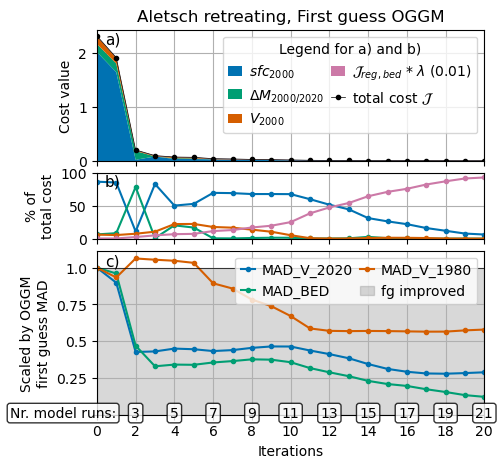

In [113]:
glacier = 'Aletsch'
glacier_state = 'retreating'
fg_method = 'oggm'

panel_labels = ['a)', 'b)', 'c)']
title_legend = 'Legend for a) and b)'

fig = plt.figure(figsize=(5, 5))

gs = GridSpec(3, 1, height_ratios=[0.8, 0.4, 1], hspace=0.1)

ax_cost = fig.add_subplot(gs[0, 0])
ax_rel = fig.add_subplot(gs[1, 0])
ax_stats = fig.add_subplot(gs[2, 0])

plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats,
                              ax_rel=ax_rel, title_legend=title_legend, fig=fig)

for panel_label, ax in zip(panel_labels,
                           [ax_cost, ax_rel, ax_stats]):
    ax.text(
        0.02, 0.98, panel_label,
        va='top',
        ha='left',
        transform=ax.transAxes,
        fontsize=11,
        zorder=10,
    )

output_filename = f'{glacier}_{glacier_state}_cost_fct_fg_{fg_method}_with_relative'

#fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
            dpi=300, bbox_inches='tight')

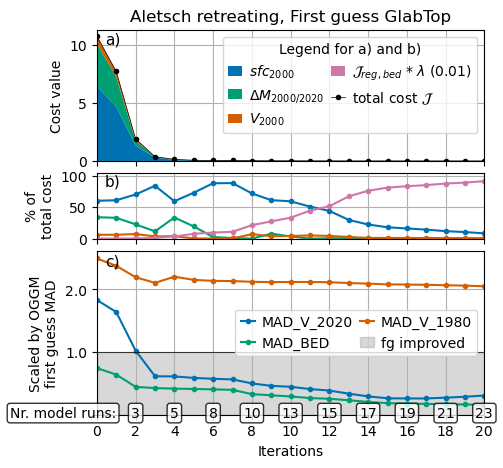

In [114]:
glacier = 'Aletsch'
glacier_state = 'retreating'
fg_method = 'glabtop'

panel_labels = ['a)', 'b)', 'c)']
title_legend = 'Legend for a) and b)'

fig = plt.figure(figsize=(5, 5))

gs = GridSpec(3, 1, height_ratios=[0.8, 0.4, 1], hspace=0.1)

ax_cost = fig.add_subplot(gs[0, 0])
ax_rel = fig.add_subplot(gs[1, 0])
ax_stats = fig.add_subplot(gs[2, 0])

plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats,
                              ax_rel=ax_rel, title_legend=title_legend, fig=fig)

for panel_label, ax in zip(panel_labels,
                           [ax_cost, ax_rel, ax_stats]):
    ax.text(
        0.02, 0.98, panel_label,
        va='top',
        ha='left',
        transform=ax.transAxes,
        fontsize=11,
        zorder=10,
    )

output_filename = f'{glacier}_{glacier_state}_cost_fct_fg_{fg_method}_with_relative'

#fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
            dpi=300, bbox_inches='tight')

## without relative cost terms

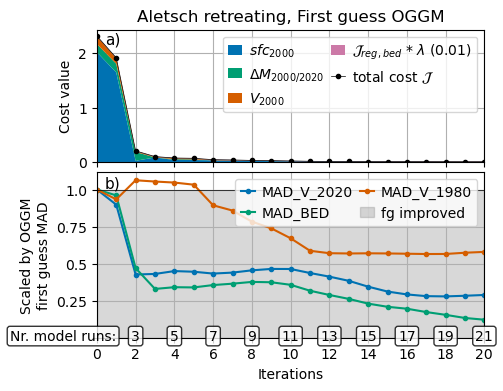

In [115]:
glacier = 'Aletsch'
glacier_state = 'retreating'
fg_method = 'oggm'

panel_labels = ['a)', 'b)']

fig = plt.figure(figsize=(5, 4))

gs = GridSpec(2, 1, height_ratios=[0.8, 1], hspace=0.07)

ax_cost = fig.add_subplot(gs[0, 0])
ax_stats = fig.add_subplot(gs[1, 0])

plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats, fig=fig)

for panel_label, ax in zip(panel_labels,
                           [ax_cost, ax_stats]):
    ax.text(
        0.02, 0.98, panel_label,
        va='top',
        ha='left',
        transform=ax.transAxes,
        fontsize=11,
        zorder=10,
    )

output_filename = f'{glacier}_{glacier_state}_cost_fct_fg_{fg_method}'

#fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
            dpi=300, bbox_inches='tight')

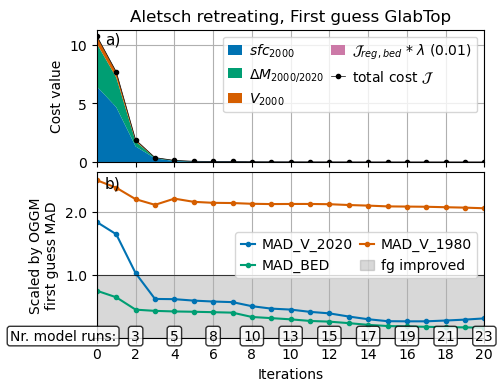

In [116]:
glacier = 'Aletsch'
glacier_state = 'retreating'
fg_method = 'glabtop'

panel_labels = ['a)', 'b)']

fig = plt.figure(figsize=(5, 4))

gs = GridSpec(2, 1, height_ratios=[0.8, 1], hspace=0.07)

ax_cost = fig.add_subplot(gs[0, 0])
ax_stats = fig.add_subplot(gs[1, 0])

plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats, fig=fig)

for panel_label, ax in zip(panel_labels,
                           [ax_cost, ax_stats]):
    ax.text(
        0.02, 0.98, panel_label,
        va='top',
        ha='left',
        transform=ax.transAxes,
        fontsize=11,
        zorder=10,
    )

output_filename = f'{glacier}_{glacier_state}_cost_fct_fg_{fg_method}'

#fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
            dpi=300, bbox_inches='tight')

# function for plotting two glaciers

In [22]:
def plot_two_glaciers(glaciers, glacier_states, fg_methods, panel_labels_all, title_legends):
    fig = plt.figure(figsize=(5, 11))
    
    gs = GridSpec(7, 1, height_ratios=[0.8, 0.4, 1, 0.4,
                                       0.8, 0.4, 1,
                                      ], hspace=0.1)
    
    ax_cost_all = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[4, 0])]
    ax_rel_all = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[5, 0])]
    ax_stats_all = [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[6, 0])]
    
    for (glacier, glacier_state, fg_method, ax_cost, ax_stats, ax_rel,
         title_legend, panel_labels)  in zip(
        glaciers, glacier_states, fg_methods, ax_cost_all, ax_stats_all, ax_rel_all,
        title_legends, panel_labels_all,
    ):
    
        plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats,
                                      ax_rel=ax_rel, title_legend=title_legend, fig=fig)
        
        for panel_label, ax in zip(panel_labels,
                                   [ax_cost, ax_rel, ax_stats]):
            ax.text(
                0.02, 0.98, panel_label,
                va='top',
                ha='left',
                transform=ax.transAxes,
                fontsize=11,
                zorder=10,
            )
    
    output_filename = ''
    for glacier, glacier_state, fg_method in zip(glaciers, glacier_states, fg_methods):
        output_filename += f'{glacier}_{glacier_state}_{fg_method}_'
    output_filename += f'cost_fct_with_relative'
    
    #fig.tight_layout()
    #plt.show()
    plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
                dpi=300, bbox_inches='tight')

# Aletsch retreating oggm and glabtop

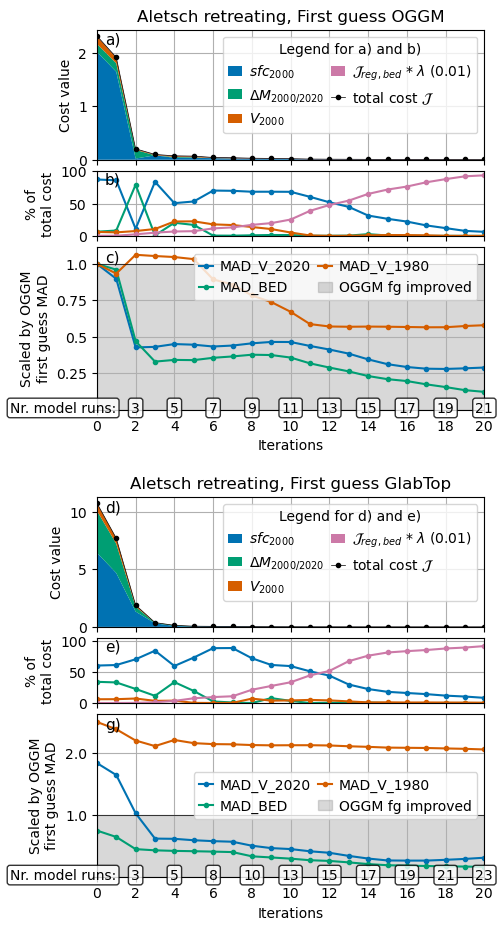

In [23]:
glaciers = ['Aletsch', 'Aletsch']
glacier_states = ['retreating', 'retreating']
fg_methods = ['oggm', 'glabtop']

panel_labels_all = [
    ['a)', 'b)', 'c)'],
    ['d)', 'e)', 'g)'],
]
title_legends = [
    'Legend for a) and b)',
    'Legend for d) and e)',
]

plot_two_glaciers(glaciers, glacier_states, fg_methods, panel_labels_all, title_legends)

# Aletsch oggm equilibrium and Baltoro glabtop retreating

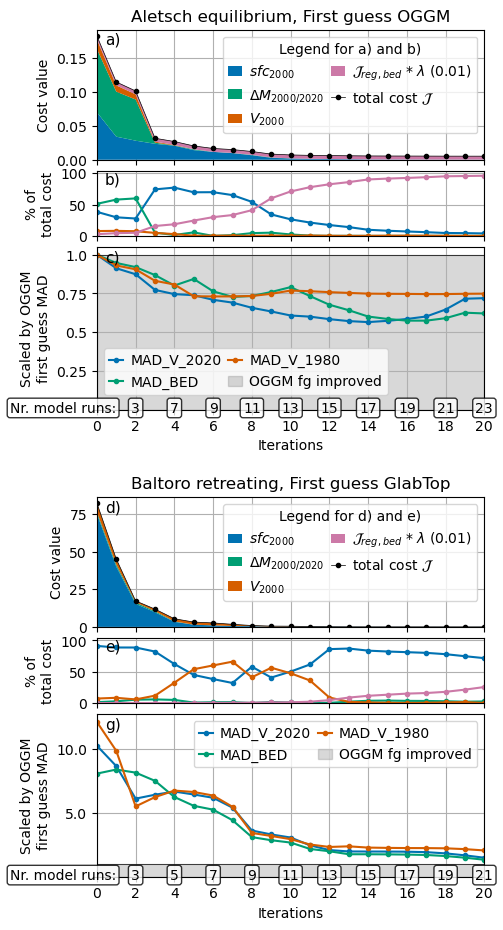

In [25]:
glaciers = ['Aletsch', 'Baltoro']
glacier_states = ['equilibrium', 'retreating']
fg_methods = ['oggm', 'glabtop']

panel_labels_all = [
    ['a)', 'b)', 'c)'],
    ['d)', 'e)', 'g)'],
]
title_legends = [
    'Legend for a) and b)',
    'Legend for d) and e)',
]

plot_two_glaciers(glaciers, glacier_states, fg_methods, panel_labels_all, title_legends)

# Artesonrajo advancing and peyto retreating oggm

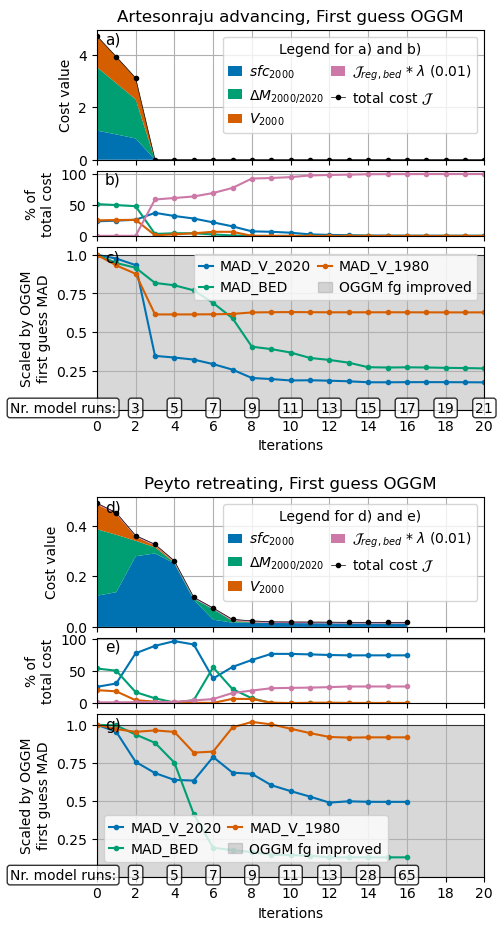

In [24]:
glaciers = ['Artesonraju', 'Peyto']
glacier_states = ['advancing', 'retreating']
fg_methods = ['oggm', 'oggm']

panel_labels_all = [
    ['a)', 'b)', 'c)'],
    ['d)', 'e)', 'g)'],
]
title_legends = [
    'Legend for a) and b)',
    'Legend for d) and e)',
]

plot_two_glaciers(glaciers, glacier_states, fg_methods, panel_labels_all, title_legends)

# Baltoro retreating glabtop

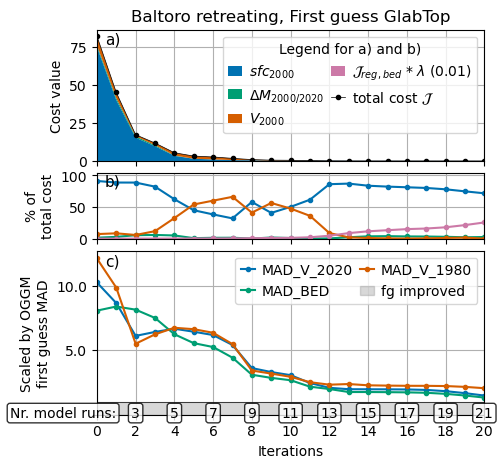

In [15]:
glacier = 'Baltoro'
glacier_state = 'retreating'
fg_method = 'glabtop'

panel_labels = ['a)', 'b)', 'c)']
title_legend = 'Legend for a) and b)'

fig = plt.figure(figsize=(5, 5))

gs = GridSpec(3, 1, height_ratios=[0.8, 0.4, 1], hspace=0.1)

ax_cost = fig.add_subplot(gs[0, 0])
ax_rel = fig.add_subplot(gs[1, 0])
ax_stats = fig.add_subplot(gs[2, 0])

plot_cost_stats_glacier_state(glacier, glacier_state, fg_method, ax_cost, ax_stats,
                              ax_rel=ax_rel, title_legend=title_legend, fig=fig)

for panel_label, ax in zip(panel_labels,
                           [ax_cost, ax_rel, ax_stats]):
    ax.text(
        0.02, 0.98, panel_label,
        va='top',
        ha='left',
        transform=ax.transAxes,
        fontsize=11,
        zorder=10,
    )

output_filename = f'{glacier}_{glacier_state}_cost_fct_fg_{fg_method}_with_relative'

#fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(output_folder, f'{output_filename}.png'),
            dpi=300, bbox_inches='tight')

# Plotting all glaciers and glacier states

## with relative

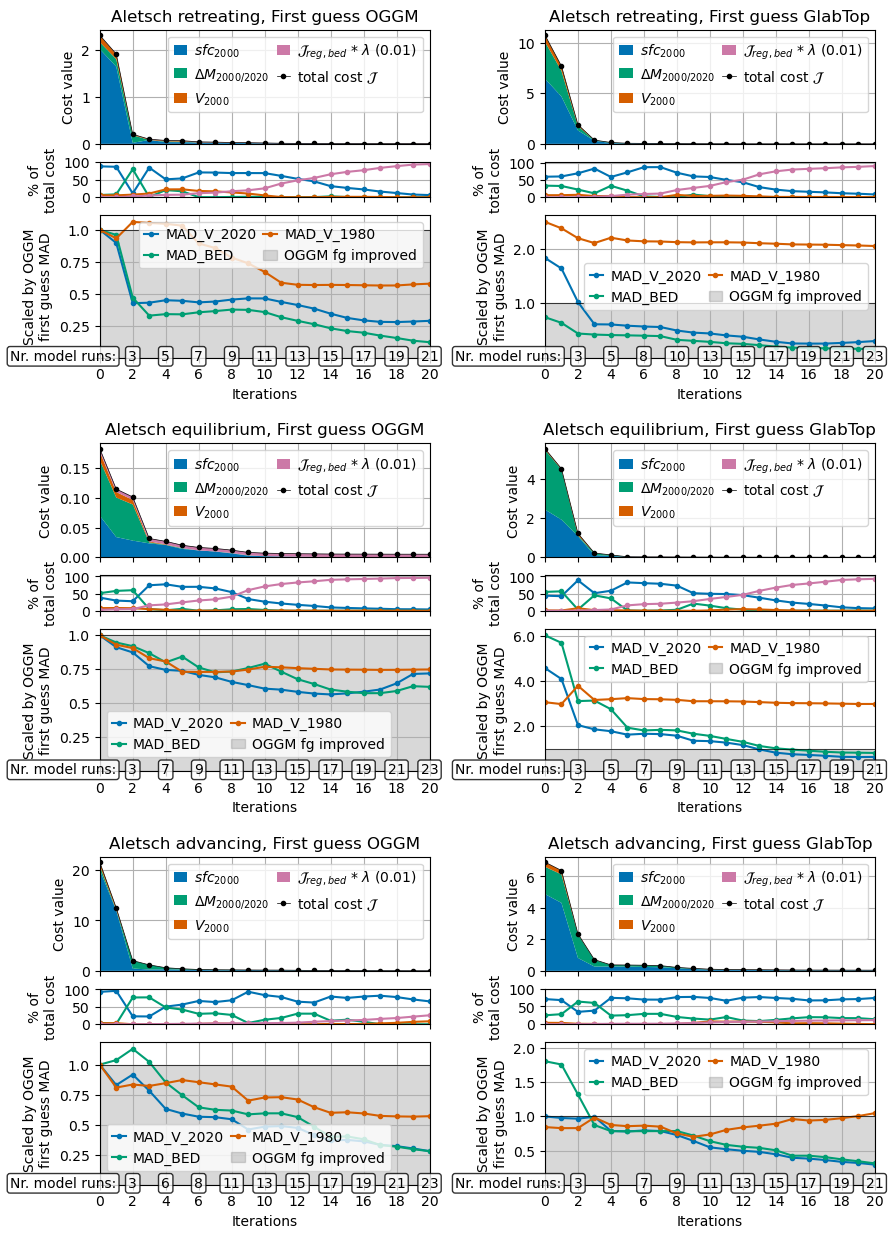

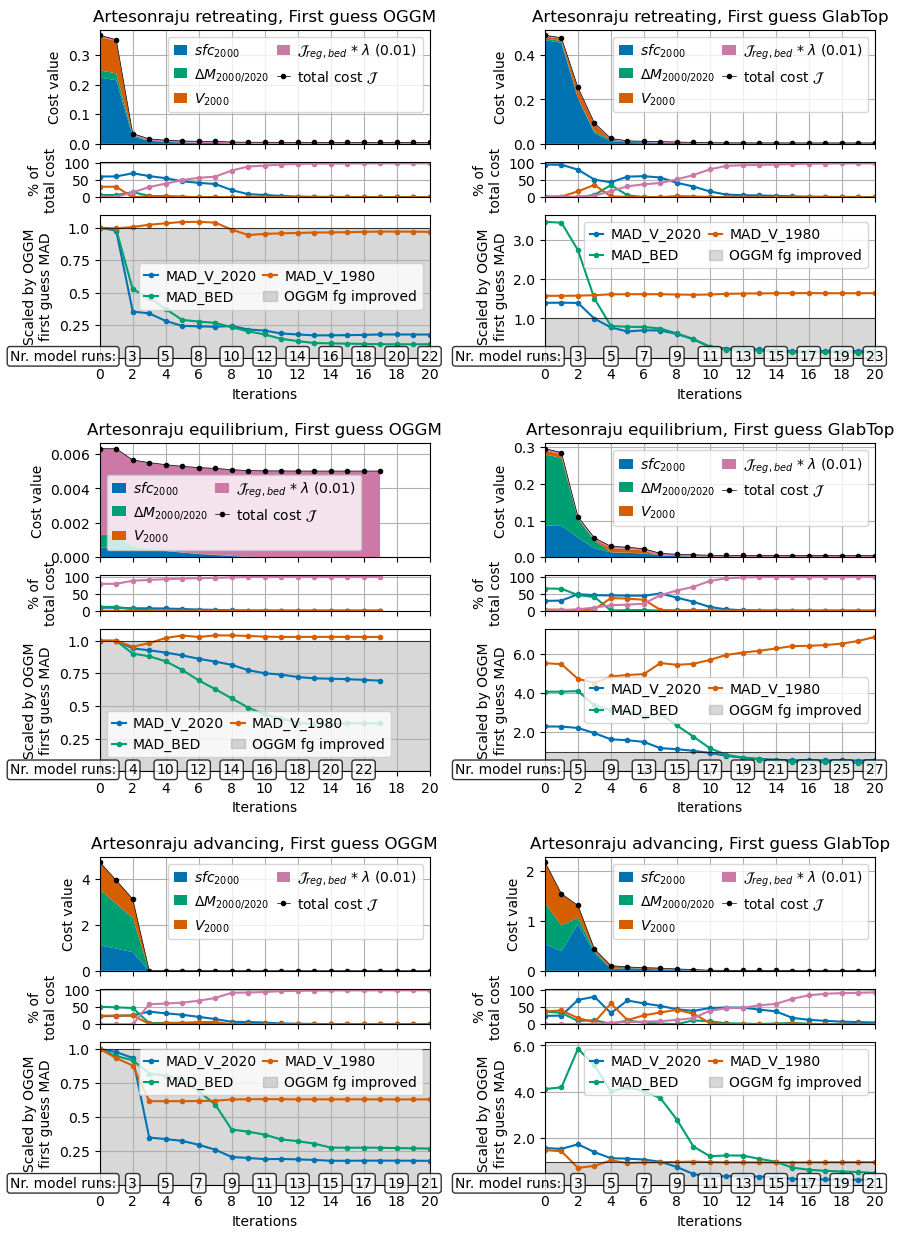

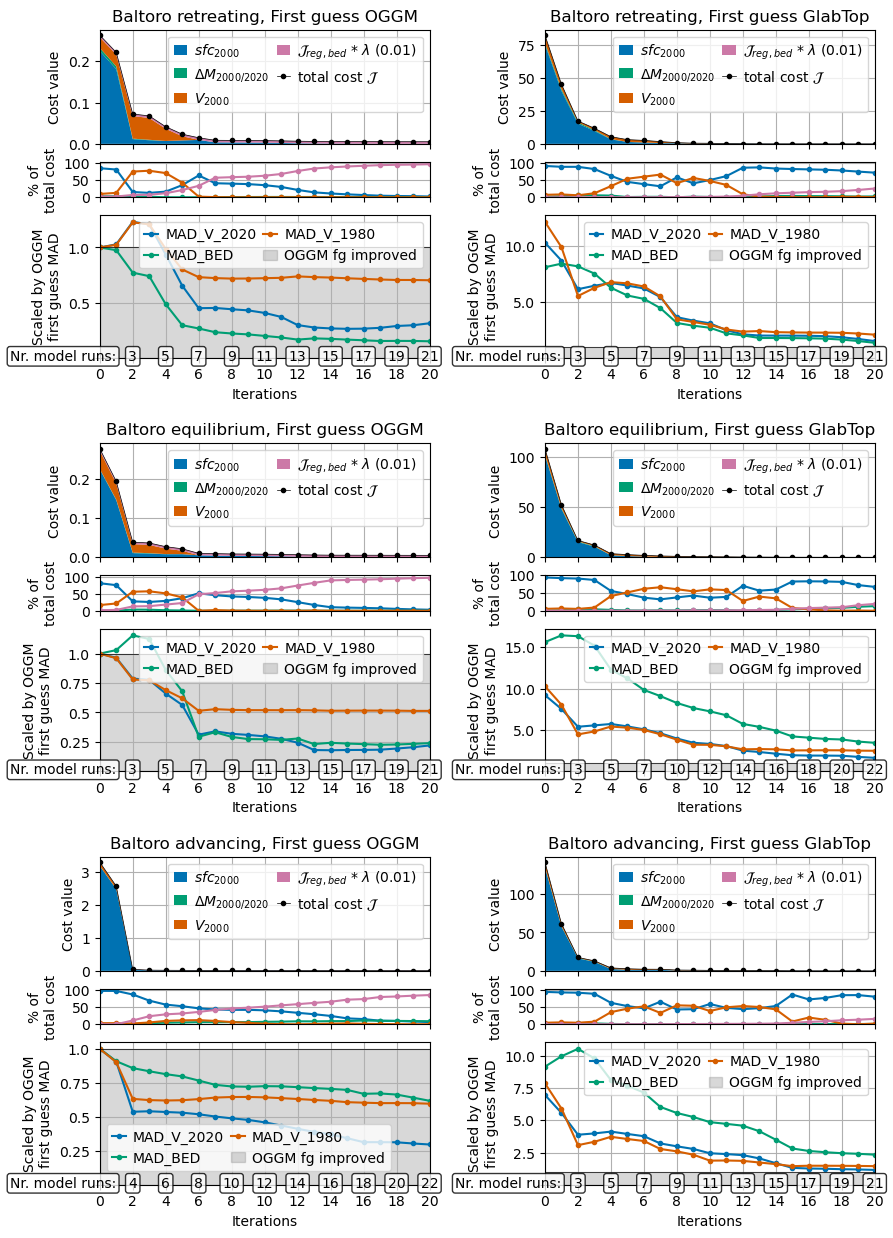

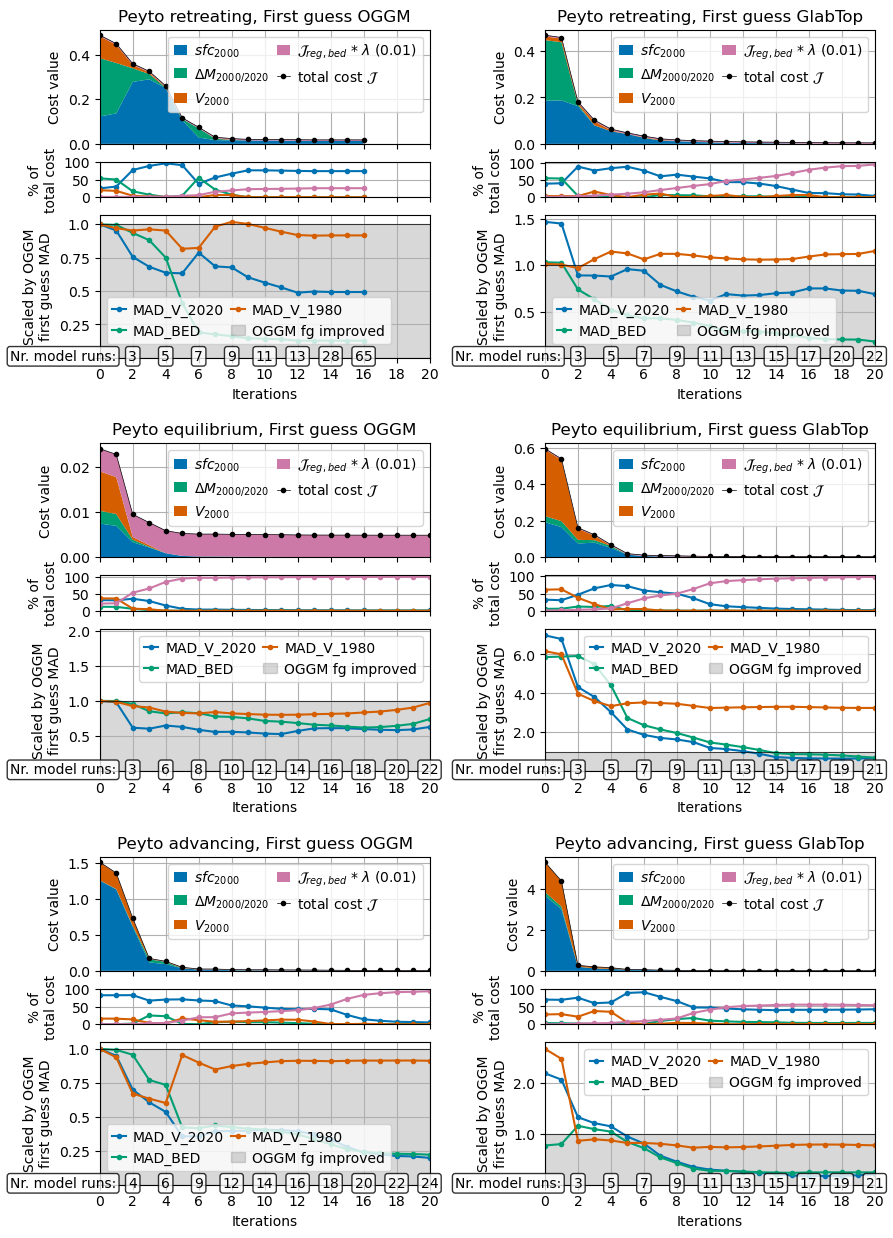

In [28]:
glaciers = sorted(experiment_glaciers)
glacier_states=['retreating', 'equilibrium', 'advancing']

for glacier in glaciers:
    fig = plt.figure(figsize=(10, 15))

    space_between_h = 0.35
    gs = GridSpec(11, 2,
                  height_ratios=[0.8, 0.25, 1, space_between_h,
                                 0.8, 0.25, 1, space_between_h,
                                 0.8, 0.25, 1,
                                ],
                  hspace=0.2,
                  wspace=0.35,
                 )

    for row, glacier_state in enumerate(glacier_states):
        start_row = row * 4
        
        ax_cost_oggm = fig.add_subplot(gs[start_row, 0])
        ax_rel_oggm = fig.add_subplot(gs[start_row + 1, 0])
        ax_stats_oggm = fig.add_subplot(gs[start_row + 2, 0])
        ax_cost_glabtop = fig.add_subplot(gs[start_row, 1])
        ax_rel_glabtop = fig.add_subplot(gs[start_row + 1, 1])
        ax_stats_glabtop = fig.add_subplot(gs[start_row + 2, 1])

        plot_cost_stats_glacier_state(glacier, glacier_state,
                                      'oggm', ax_cost_oggm, ax_stats_oggm,
                                      ax_rel=ax_rel_oggm, fig=fig)
        plot_cost_stats_glacier_state(glacier, glacier_state,
                                      'glabtop', ax_cost_glabtop, ax_stats_glabtop,
                                      ax_rel=ax_rel_glabtop, fig=fig)

    output_filename = f'{glacier}_cost_fct_all'

    #fig.tight_layout()
    #plt.show()
    plt.savefig(os.path.join(output_folder, f'{output_filename}_with_relative.png'),
                dpi=300, bbox_inches='tight')

## without relative

In [23]:
glaciers = sorted(experiment_glaciers)
glacier_states=['retreating', 'equilibrium', 'advancing']

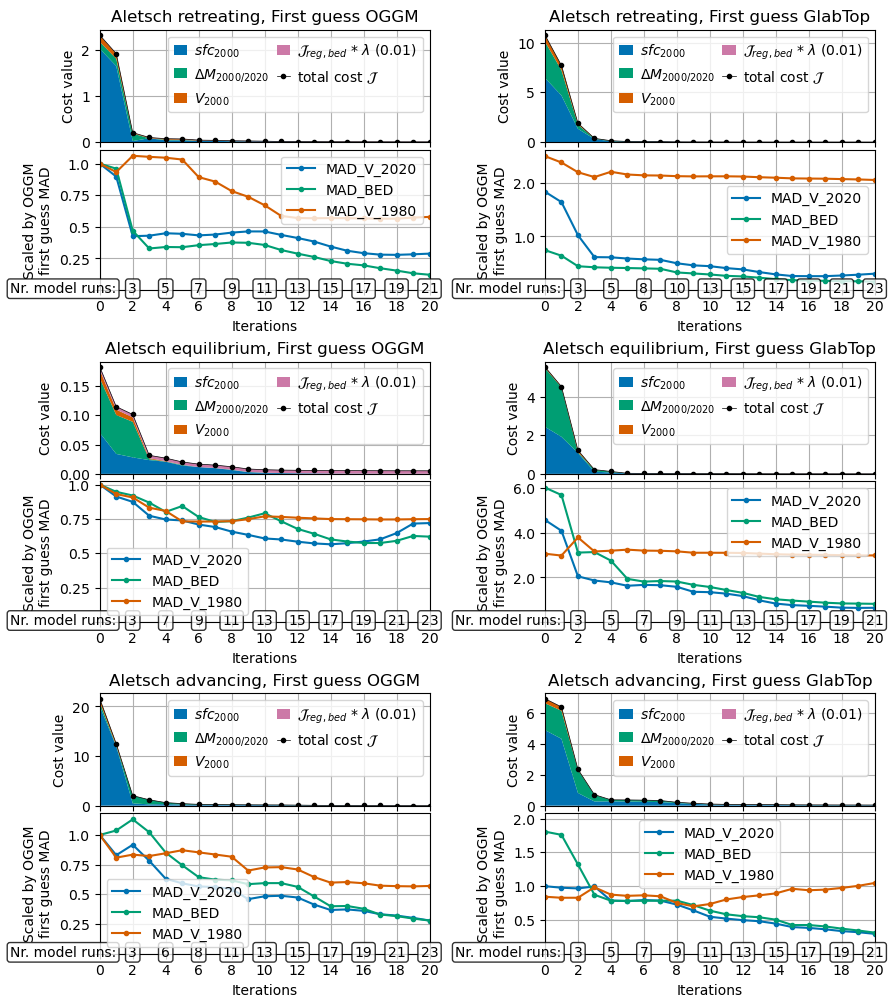

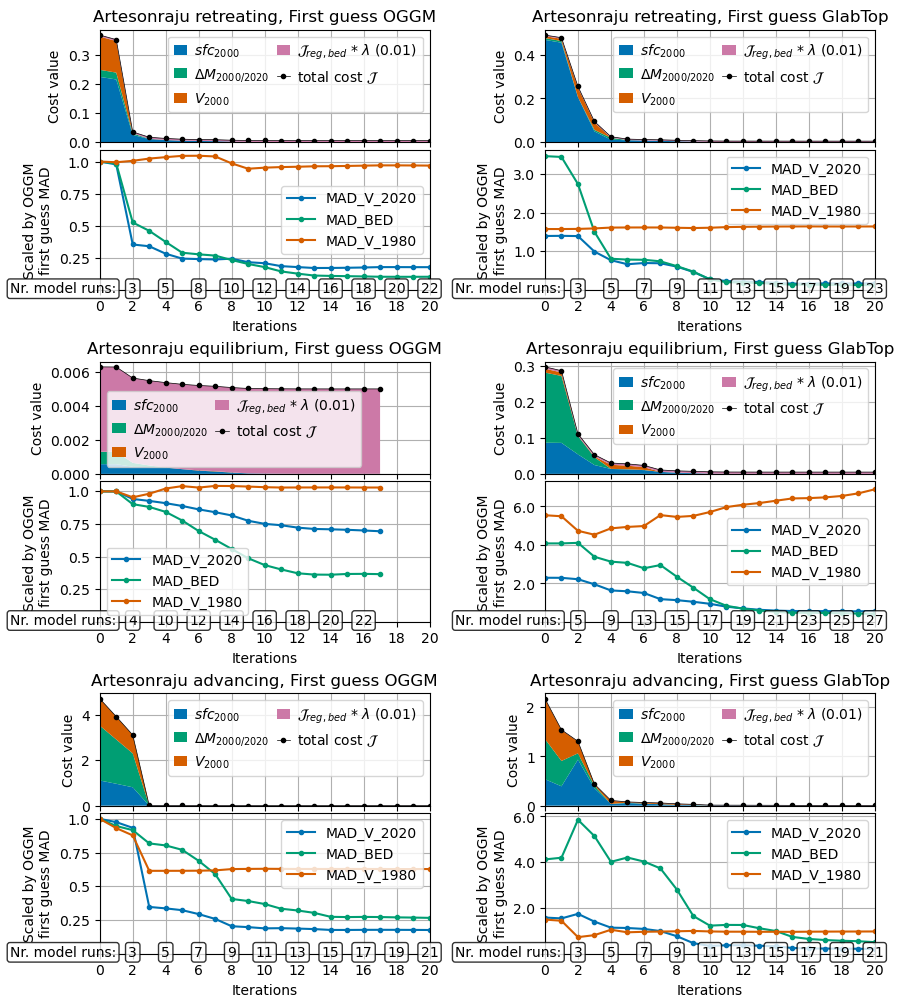

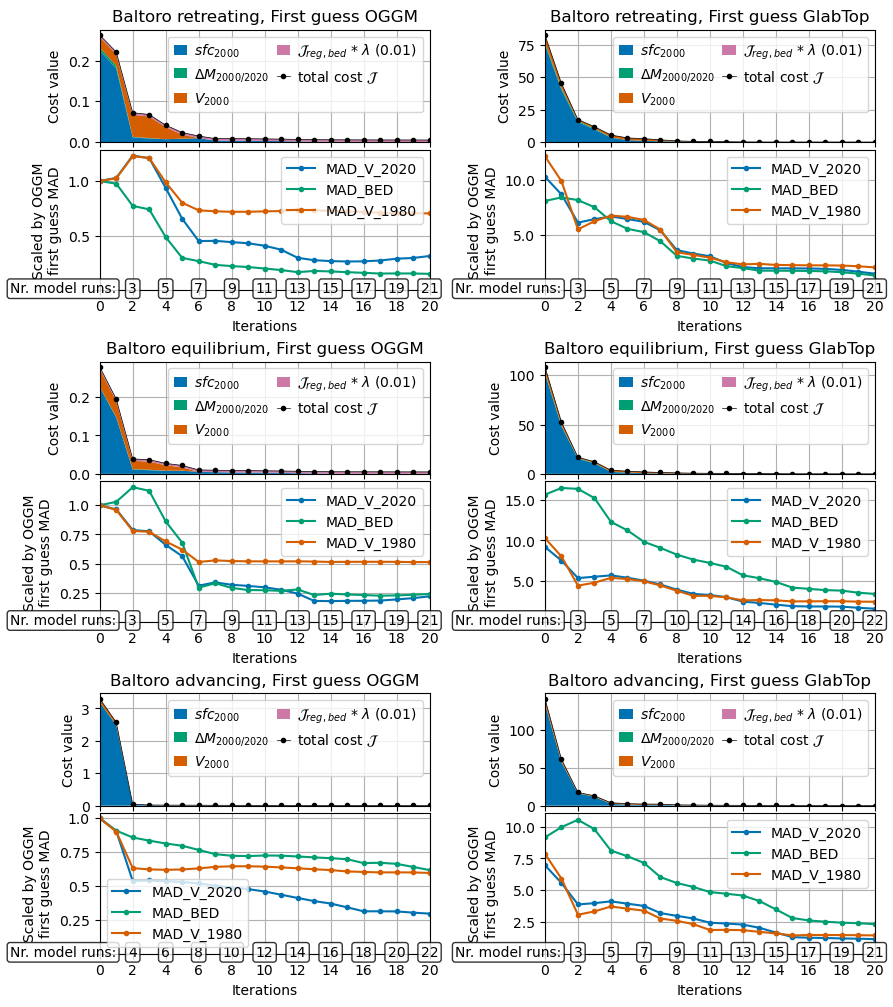

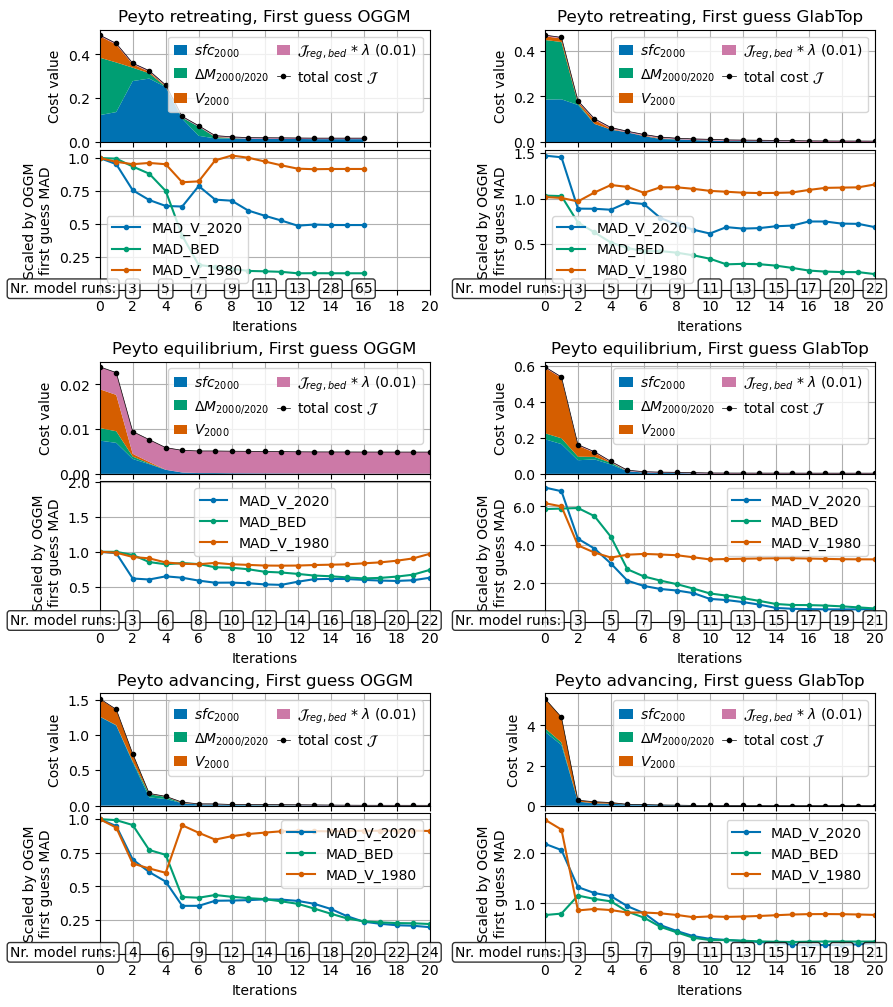

In [90]:
for glacier in glaciers:
    fig = plt.figure(figsize=(10, 12))

    space_between_h = 0.4
    gs = GridSpec(8, 2,
                  height_ratios=[0.8, 1, space_between_h,
                                 0.8, 1, space_between_h,
                                 0.8, 1,
                                ],
                  hspace=0.07,
                  wspace=0.35,
                 )

    for row, glacier_state in enumerate(glacier_states):
        start_row = row * 3
        
        ax_cost_oggm = fig.add_subplot(gs[start_row, 0])
        ax_stats_oggm = fig.add_subplot(gs[start_row + 1, 0])
        ax_cost_glabtop = fig.add_subplot(gs[start_row, 1])
        ax_stats_glabtop = fig.add_subplot(gs[start_row + 1, 1])

        plot_cost_stats_glacier_state(glacier, glacier_state,
                                      'oggm', ax_cost_oggm, ax_stats_oggm, fig=fig)
        plot_cost_stats_glacier_state(glacier, glacier_state,
                                      'glabtop', ax_cost_glabtop, ax_stats_glabtop, fig=fig)

    output_filename = f'{glacier}_cost_fct_all'

    #fig.tight_layout()
    #plt.show()
    plt.savefig(os.path.join(output_folder, f'{output_filename}.pdf'),
                dpi=300, bbox_inches='tight')